# Defining and Training Neural Networks

What we will learn:
- How to initialize a NN
- Forward pass
- Backward pass
- Optimization of the network parameters

## Pytorch: <code>nn</code>

The <code>nn</code> package defines a set of Modules (i.e. neural networks layers).

Each module receive an input and produces an output.

The <code>nn</code> package also defines losses. 

In [1]:
# Import libs
import torch
import torch.nn as nn

import math
from IPython import display

### Objective
Create a model that approximate the $sin(x)$ function.

In [2]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

In [3]:
# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)
print(xx.size())

torch.Size([2000, 3])


In [4]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)

In [5]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
# Construct the Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### MSE Loss
$$\mathcal{L}_{MSE} = \frac{1}{n}\sum^n_{i=n}(y - \hat{y})^2$$

In [6]:
for t in range(2000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y) # (y_pred - y).pow(2).mean()
    if t % 200 == 199:
        print(t, loss.item())
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()
    
    # Alternative: zero the gradients of the model
    # model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward() 

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Alternative: Update the weights using gradient descent MANUALLY. Each parameter is a Tensor, so
    # we can access its gradients.
    """
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    """

199 0.08092053234577179
399 0.055624619126319885
599 0.038715261965990067
799 0.0274051483720541
999 0.019835200160741806
1199 0.014765077270567417
1399 0.01136691402643919
1599 0.009087617509067059
1799 0.007557665463536978
1999 0.006529884412884712


In [7]:
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

Result: y = -0.03632292523980141 + 0.8028499484062195 x + 0.006266308017075062 x^2 + -0.08566486835479736 x^3


In [8]:
# The network has effectively learned something?
print(xx[500]) # x[500] = -pi/2
print("%.6f %.6f" % (model(xx)[500].item(), torch.sin(x)[500]))

tensor([-1.5700,  2.4649, -3.8700])
-0.949839 -1.000000


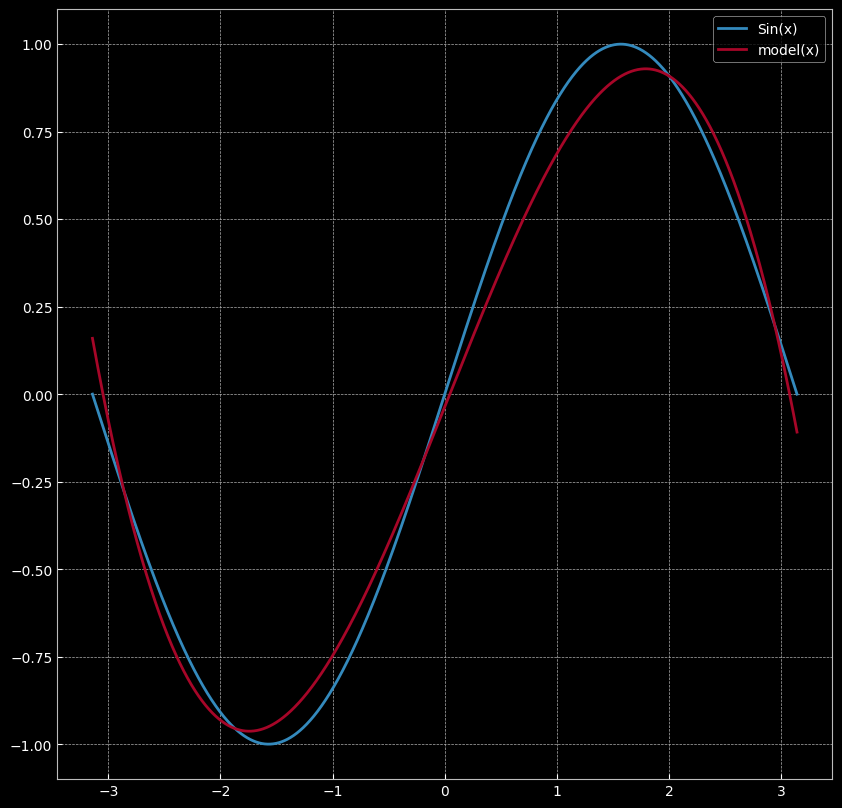

In [18]:
# plot results
import matplotlib.pyplot as plt
from res.plot_lib import plot_data, plot_data_np, plot_model, set_default
set_default()

yy = model(xx)

plt.plot(x,y, label='Sin(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()

## Custom models

In [19]:
class SinModel(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate all the layer of the NN
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 1),
            nn.Flatten(0, 1)
        )
        """
        In alternative we could also define each layer individually
        """
        # self.l1 = nn.Linear(3, 1)
        # self.flt = nn.Flatten(0, 1)
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.model(x)
        # x = self.l1(x)
        # return self.flt(x)

In [20]:
# Construct our model by instantiating the class defined above
model = SinModel()

In [21]:
# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(xx)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 200 == 199:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

199 0.1598684936761856
399 0.10723990201950073
599 0.07242859899997711
799 0.04940212890505791
999 0.03417102247476578
1199 0.024096133187413216
1399 0.01743183471262455
1599 0.013023516163229942
1799 0.010107452049851418
1999 0.008178510703146458


In [22]:
# The network has effectively learned something?
print(xx[500]) # x[500] = -pi/2
print("%.6f %.6f" % (model(xx)[500].item(), torch.sin(x)[500]))

tensor([-1.5700,  2.4649, -3.8700])
-0.895024 -1.000000


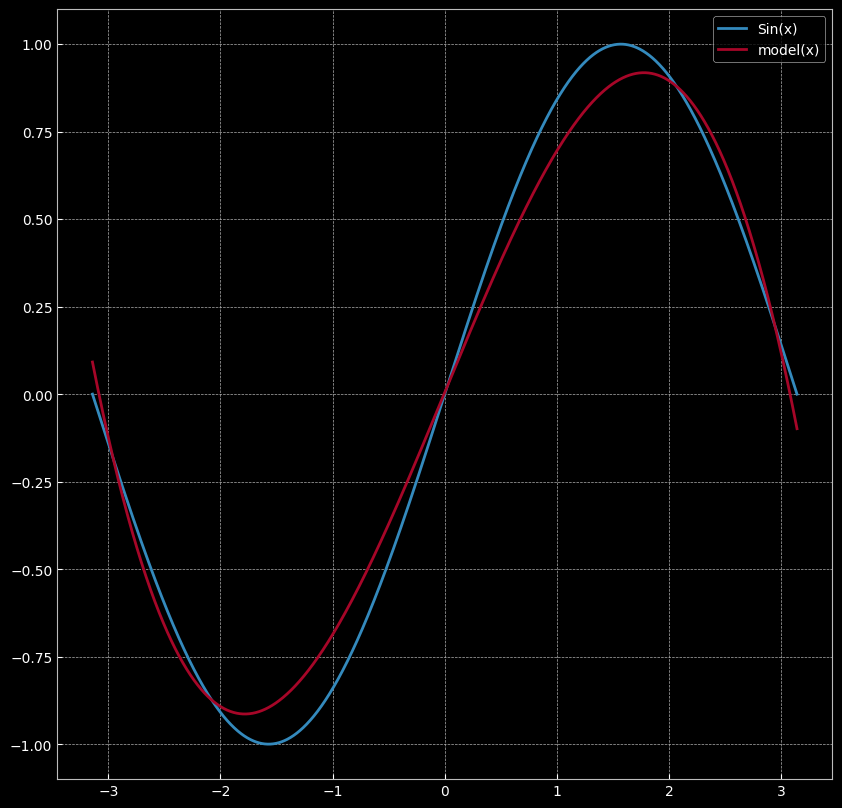

In [23]:
yy = model(xx)

plt.plot(x,y, label='Sin(x)')
plt.plot(x,yy.detach().numpy(), label='model(x)')
plt.legend()
plt.show()

In [13]:
# Ex1: write a model (using custom modules) where the output y is a linear function of (x, x^2, x^3, x^4)
# and it approximate the cosine function

In [14]:
# Ex2: write a model (using custom modules) where the output y is a linear function of (x, x^2, x^3)
# and it approximate the function -5 + 2*x + 3/4x^2 + 7*x^3